In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

import glob
import os
import logging
import datetime
import warnings
import re
import sys 
from skimage import io

from copy import deepcopy
from lmfit.models import GaussianModel, LorentzianModel

# from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['errorbar.capsize'] = 5
plt.rcParams['lines.markersize'] = 4.

In [88]:
def get_power_setting(file):
    dfset = pd.read_csv(file, sep=':', names=['setting', 'value'])
    dfset.set_index('setting', inplace=True)
    power = float(dfset.loc['POWER(uW)'].value)
    return power

In [99]:
def power_run_analysis(path, roi, filebg, label = None ):

    files = glob.glob(path)
    files.sort()

    imdark = io.imread(filebg).astype(np.int64)

    avInt = []
    unInt = []
    pows = []

    for f in files:
        # name = os.path.split(f)[1]
        dirf = os.path.split(f)[0]
        power = get_power_setting(dirf+'/settings.json')
        # power = float(re.search(r'([-+]?\d\.\d+e[-+]?\d+)', name).group(1))
        pows.append(power)
        
        img = io.imread(f).astype(np.int64)
        # if filebg != None:
        img -= imdark                            #  Live subtract imdark (filter 2)
        imroi = img[roi[0]:roi[1], roi[2]:roi[3]]
        roiSize = imroi.shape[0] * imroi.shape[1]

        intPx = imroi.sum()/roiSize
        avInt.append(intPx)
        
        unPx = np.sqrt((imroi**2).sum()) / roiSize
        unInt.append(unPx)

    plt.errorbar(x=pows, y=avInt, yerr=unInt, fmt='o', label=label)
    plt.gca().set(xlabel='Power (W)', ylabel='Counts/px')

    dfres = pd.DataFrame({'power': pows, 'counts': avInt, 'dcounts': unInt})
    return dfres

# Set ROI

In [109]:
roi = [400, 1300, 700, 1700]
rootpath = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/'
diodepath = rootpath+'sing/30-01-25/Rhodamine-B 50 diode'
filebg = rootpath+'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/1/Dark_Blind_15-03-27.tif'

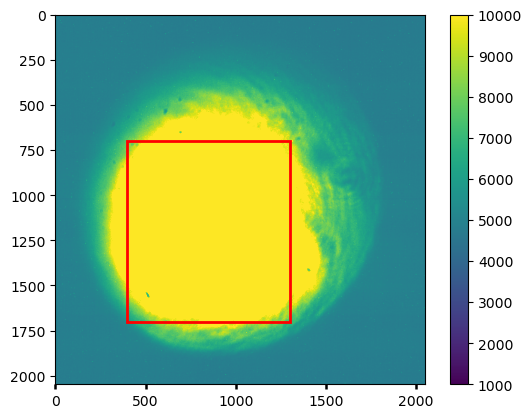

In [110]:
filetest = rootpath+ 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/1/Center-586nm_Width-26nm_15-03-27.tif'
img = io.imread(filetest).astype(np.int64)

imroi = img[roi[0]:roi[1], roi[2]:roi[3]]
roiSize = imroi.shape[0] * imroi.shape[1]
plt.imshow(img, origin='upper', clim=(1e3, 1e4))
square = patches.Rectangle((roi[0], roi[2]), roi[1]-roi[0], roi[3]-roi[2], edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(square)
plt.colorbar()

# Calibration: Rhodamine-B 50 µM with TOptica laser

[Text(0.5, 1.0, 'Rhodamine-B 50 µM')]

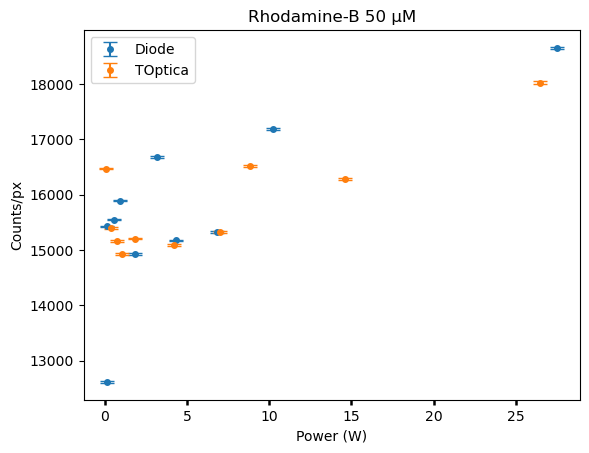

In [100]:
prhod_top = rootpath+ 'sing/30-01-25/Rhodamine-B 50 diode/**/*.tif'
dfrhod = power_run_analysis(prhod_top, roi, filebg=filebg, label='Diode')

prhod_top = rootpath+ 'sing/30-01-25/Rhodamine-B 50 µM TOptica/**/*.tif'
dfrhod = power_run_analysis(prhod_top, roi, filebg=filebg, label='TOptica')
plt.legend()
plt.gca().set(title='Rhodamine-B 50 µM')

# Quartz, TOptica and diode lasers

In [172]:
p_top = rootpath + 'quartz_toptica' +'/**/*.tif'
dftop = power_run_analysis(p_top, roi, filebg=filebg)

p_dd = rootpath + 'quartz_diode' +'/**/*.tif'
dfdd = power_run_analysis(p_dd, roi, filebg=filebg)

dfdd['power'] = dfdd['power'].sort_values().reset_index(drop=True)
dfdd['power'] = dfdd['power'].apply(lambda x: x/1e-6)

dftop['power'] = dftop['power'].sort_values().reset_index(drop=True)
dftop['power'] = dftop['power'].apply(lambda x: x/1e-6)

[Text(0, 0.5, 'Counts/px'),
 Text(0.5, 0, 'Power (µW)'),
 Text(0.5, 1.0, 'Quartz reflection')]

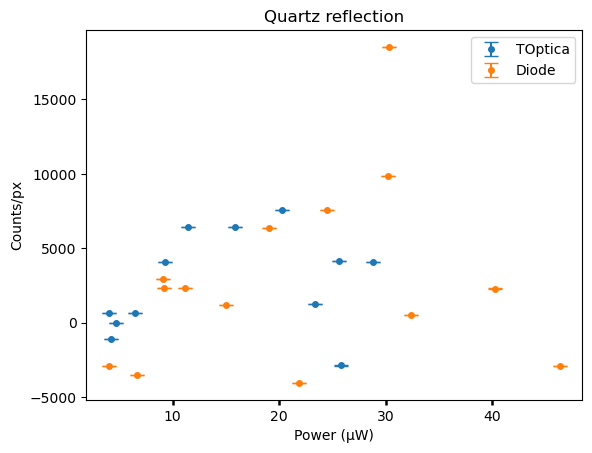

In [175]:
plt.errorbar(x=dftop.power, y=dftop.counts, yerr=dftop.dcounts, fmt='o', label='TOptica')
plt.errorbar(x=dfdd.power, y=dfdd.counts, yerr=dfdd.dcounts, fmt='o', label='Diode')
plt.legend()
plt.gca().set(title='Quartz reflection', xlabel='Power (µW)', ylabel='Counts/px')